## Preambule

In [1]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Read

In [2]:
path_main = Path("K:/Code/EffortSharing/")
path_data = Path("K:/Data/Data_EffortSharing/DataUpdate_ongoing/")
path_figs = path_main / "Figures" / "NZreport"

In [3]:
xr_dataread = xr.open_dataset(path_data / "xr_dataread.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.load(path_data / "all_regions_names.npy")
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)

In [4]:
settings_default =  {'Temperature': 1.6,
                   'Risk': 0.5,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate",
                   'Convergence_year': 2050,
                   'Scenario': 'SSP2',
                   'Discount_factor': 0,
                   'Historical_startyear': 1950,}
settings_default_global = {'Temperature': 1.6,
                   'Risk': 0.5,
                   'NegEmis': 0.5,
                   'NonCO2red': 0.5,
                   'Timing': "Immediate"}

In [5]:
xr_allocs = []
for cty in ['EU', 'RWA', 'IND', 'USA', 'BRA', 'EARTH']:#list(all_countries_iso)+['EU']+['EARTH']:
    xr_allocs.append(xr.open_dataset(path_data / "Allocations_CO2_excl" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]}).sel(**settings_default)[['GF', 'ECPC', 'PCC', 'AP', 'PC']])
xr_allocs = xr.merge(xr_allocs)

# xr_allocs_incl = []
# for cty in ['EU', 'USA', 'IND', 'CHN', 'JPN', 'AUS', 'BRA', 'RUS', 'ZAF']:
#     xr_allocs_incl.append(xr.open_dataset(path_data / "Allocations_CO2_incl" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]})[['GF', 'ECPC', 'PCC', 'AP', 'PC']].sel(Temperature=1.6, Risk=0.5, NegEmis=0.5, NonCO2red=0.5, Timing='Immediate', Scenario='SSP2'))
# xr_allocs_incl = xr.merge(xr_allocs_incl)

In [6]:
# xr_allocs = []
# for cty in ['EU', 'USA', 'BRA', 'EARTH']:#list(all_countries_iso)+['EU']+['EARTH']:
#     xr_allocs.append(xr.open_dataset(path_data / "Allocations" / ("xr_alloc_"+cty+".nc")).expand_dims({'Region':[cty]}).sel(**settings_default)[['GF', 'ECPC', 'PCC', 'AP', 'PC']])
# xr_allocs = xr.merge(xr_allocs)

## Plot

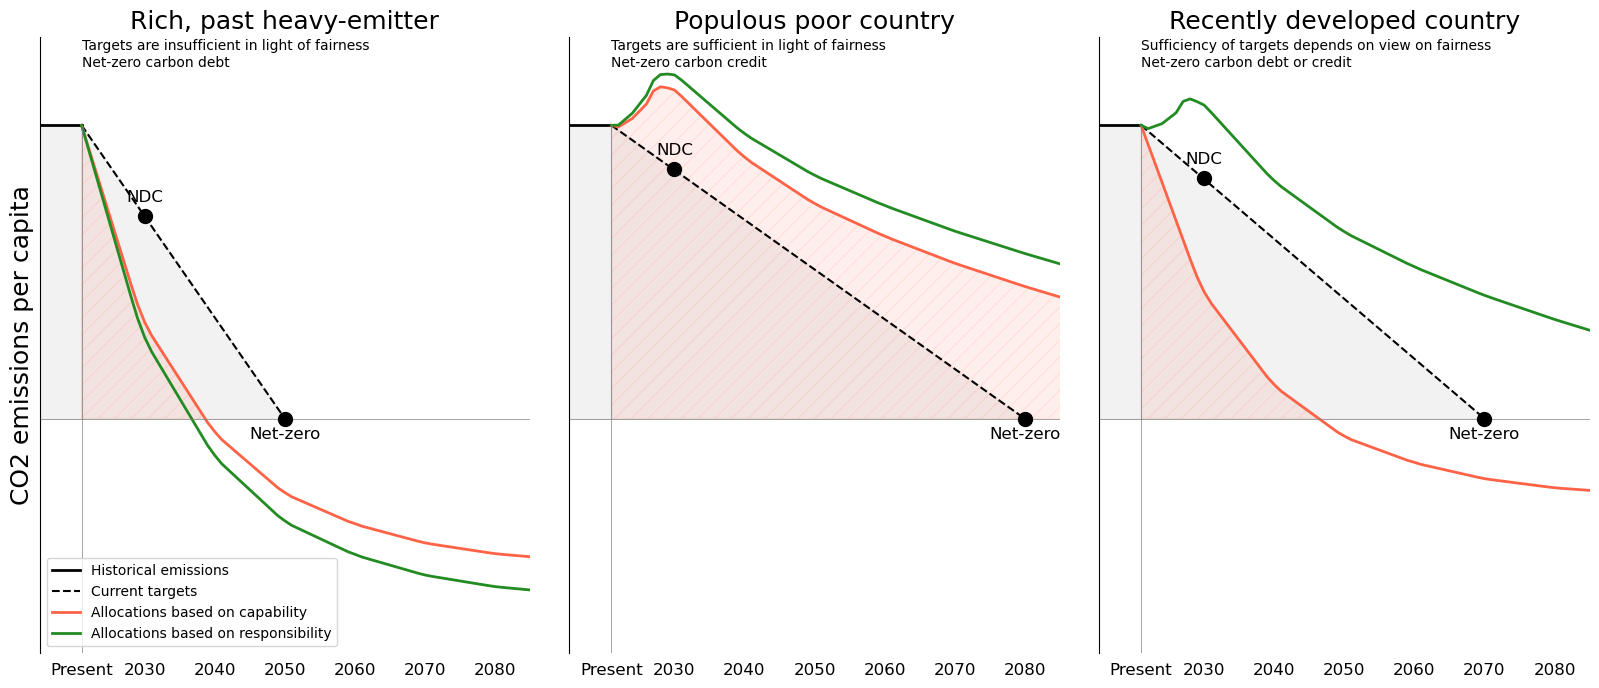

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
# set horizontal spacing
fig.subplots_adjust(wspace=0.08)
ax1.set_title("Rich, past heavy-emitter", fontsize=18)
ax2.set_title("Populous poor country", fontsize=18)
ax3.set_title("Recently developed country", fontsize=18)

# Historical emissions
for ax_i, ax in enumerate([ax1, ax2, ax3]):
    cty = 'USA'
    #pop = xr_dataread.Population.sel(Region=cty, Scenario='SSP2')
    curlev =  xr_dataread.CO2_hist_excl.sel(Region=cty).sel(Time=2021)
    ax.plot([2015, 2021], [1, 1], lw=2, label='Historical emissions', c='black')
    ax.plot([2021, [2050, 2080, 2070][ax_i]], [1, 0], '--', label='Current targets', c='black')
    #ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.8, 1.3, 1.2][ax_i]-1, lw=2, label='Allocations based on equality', c='steelblue')
    d = [[0]*len(xr_allocs.Time),
         [0, 0.03, 0.08, 0.13, 0.19, 0.25, 0.33, 0.38, 0.41, 0.43]+ list(np.linspace(0.43, 0, int(len(xr_allocs.Time)-10))),
         [0]*len(xr_allocs.Time)][ax_i]
    d2 = [d, d, [0, 0.03, 0.08, 0.13, 0.19, 0.25, 0.33, 0.38, 0.41, 0.43]+ list(np.linspace(0.43, 0, int(len(xr_allocs.Time)-10)))][ax_i]
    ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.7, 1.4, 0.9][ax_i]-1+d, lw=2, label='Allocations based on capability', c='tomato')
    ax.plot(xr_allocs.Time, 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.6, 1.5, 1.3][ax_i]-1+d2, lw=2, label='Allocations based on responsibility', c='forestgreen')

    # fill area up to 2021
    ax.fill_between(xr_dataread.Time.sel(Time=np.arange(1950, 2022)), 0, 1, color='grey', alpha=0.1)
    ax.fill_between([2021, [2050, 2080, 2070][ax_i]], [0, 0], [1, 0], color='grey', alpha=0.1)
    y = 2*xr_allocs.sel(Region=cty)['GF']/curlev+(1-xr_allocs.sel(Region=cty)['GF']/curlev) * [0.7, 1.4, 0.9][ax_i]-1+d
    ax.fill_between(xr_allocs.Time, [0]*len(y), y, where=y>=0, color='tomato', alpha=0.1, hatch='//')

    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['PCC']/curlev, label='Allocations based on equality', c='tomato')
    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['ECPC']/curlev, label='Allocations based on responsibility', c='forestgreen')
    # ax.plot(xr_allocs.Time, xr_allocs.sel(Region=cty)['AP']/curlev, label='Allocations based on capability', c='goldenrod')
    ax.set_xlim([2015, 2085])
    ax.set_ylim([-0.8, 1.3])
    ax.plot([2015, 2100], [0, 0], 'grey', lw=0.5)
    ax.plot([2021, 2021], [-1e9, 1], 'grey', lw=0.5)
    ax.plot([2030, [2050, 2080, 2070][ax_i]], [[0.69, 0.85, 0.82][ax_i], 0], 'ok', ms=10)
    ax.text(2030, [0.69, 0.85, 0.82][ax_i]-0.02, 'NDC\n', fontsize=12, ha='center', va='bottom')
    ax.text([2050, 2080, 2070][ax_i], -0.03, 'Net-zero\n', fontsize=12, ha='center', va='top')

    ax.text(2021, 1.2, ["Targets are insufficient in light of fairness\nNet-zero carbon debt",
                        'Targets are sufficient in light of fairness\nNet-zero carbon credit',
                        'Sufficiency of targets depends on view on fairness\nNet-zero carbon debt or credit'][ax_i])
ax1.set_ylabel("CO2 emissions per capita", fontsize=18)

# Turn frame axis off
for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis.set_tick_params(width=0)
    ax.set_xticks([2021, 2030, 2040, 2050, 2060, 2070, 2080])
    ax.set_xticklabels(['Present', '2030', '2040', '2050', '2060', '2070', '2080'], fontsize=12)
    ax.set_yticks([])

ax1.legend(loc='lower left')
plt.savefig(path_figs / "Conceptual.png", bbox_inches='tight', dpi=300)
plt.savefig(path_figs / "Conceptual.svg", bbox_inches='tight', dpi=300)